## Задание

Добейтесь на автокодировщике с 2-мерным скрытым пространством на 3-х цифрах: 0, 1 и 3 – ошибки MSE**<0.034** на скорости обучения **0.001** на **10-й эпохе**.

## Импорт библиотек


In [ ]:
# Работа с операционной системой
import os

# Отрисовка графиков
import matplotlib.pyplot as plt

# Операции с путями
import glob

# Работа с массивами данных
import numpy as np

from tensorflow import expand_dims
import tensorflow.keras.backend as K
from tensorflow.keras.backend import sqrt
# Слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Concatenate, Dropout, Lambda

# Модель
from tensorflow.keras import Model

# Загрузка модели
from tensorflow.keras.models import load_model

# Датасет
from tensorflow.keras.datasets import mnist

# Оптимизатор для обучения модели
from tensorflow.keras.optimizers import Adam

# Коллбэки для выдачи информации в процессе обучения
from tensorflow.keras.callbacks import LambdaCallback

%matplotlib inline

## Утилиты

Функция-коллбэк. Отрисовывает объекты в скрытом пространстве

In [ ]:
def ae_on_epoch_end(epoch, logs):
    print('________________________')
    print(f'*** ЭПОХА: {epoch+1}, loss: {logs["loss"]} ***')
    print('________________________')

    # Получение картинки латентного пространства в конце эпохи и запись в файл
    # Задание числа пикселей на дюйм
    plt.figure(dpi=100)

    # Предсказание енкодера на тренировочной выборке
    predict = encoder.predict(X_train)

    # Создание рисунка: множество точек на плоскости 3-х цветов (3-х классов)
    scatter = plt.scatter(predict[:,0,],predict[:,1], c=y_train, alpha=0.6, s=5)

    # Создание легенды
    legend2 = plt.legend(*scatter.legend_elements(), loc='upper right', title='Классы')

    # Сохранение картинки с названием, которого еще нет
    paths = glob.glob('*.jpg')
    plt.savefig(f'image_{str(len(paths))}.jpg')

    # Отображение. Без него рисунок не отрисуется
    plt.show()


ae_callback = LambdaCallback(on_epoch_end=ae_on_epoch_end)

Удаление изображений. Применять при обучении новой модели, чтобы не было путаницы в картинках.

In [ ]:
def clean():
  # Получение названий всех картинок
  paths = glob.glob('*.jpg')

  # Удаление всех картинок по полученным путям
  for p in paths:
    os.remove(p)

# Удаление всех картинок
clean()

## Загрузка данных

In [ ]:
# Загрузка датасета
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
# Нормировка
X_train = X_train.astype('float32')/255.
X_train = X_train.reshape(-1, 28, 28, 1)

In [ ]:
# Выбор визуализируемых классов (цифр) и формирование подвыборок для них по маске
numbers = [0, 1, 3]
mask = np.array([(i in numbers) for i in y_train])
X_train = X_train[mask]
y_train = y_train[mask]

## Создание модели и обучение

In [ ]:
hidden_dim = 2

#энкодер
input_img = Input((28, 28, 1))
x = Conv2D(8, 3, padding='same', dilation_rate=2, activation='elu')(input_img)  #28, 28
x = BatchNormalization()(x)
x = Conv2D(16, 3, padding='same', dilation_rate=2, activation='elu')(x)
x = BatchNormalization()(x)
x = Conv2D(32, 3, padding='same', activation='elu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, 3, padding='same', strides=2, activation='elu')(x)               #14, 14
x = BatchNormalization()(x)
x = Conv2D(64, 3, padding='same', activation='elu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, 3, padding='same', strides=2, activation='elu')(x)               #7, 7
x = BatchNormalization()(x)
x = Conv2D(128, 3, padding='same', activation='elu')(x)
x = BatchNormalization()(x)

pre_flat_shape = x.shape[1:]
x = Flatten()(x)
flat_shape = x.shape[1]

x = Dense(256, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(32, activation='elu')(x)
x = BatchNormalization()(x)
encoder_outputs = Dense(hidden_dim)(x)

encoder = Model(input_img, encoder_outputs, name='encoder')

#декодер
x = encoder_outputs
x = Concatenate(axis=-1)([x, x ** 2, sqrt(sqrt(x ** 2))])
x = Dense(32, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(flat_shape)(x)
x = Reshape(pre_flat_shape)(x)

x = Conv2D(512, 3, padding='same', activation='elu')(x)                        #7, 7
x = BatchNormalization()(x)
x = Conv2DTranspose(256, 3, strides=2, padding='same', activation='elu')(x)    #14, 14
x = BatchNormalization()(x)
x = Conv2D(256, 3, padding='same', activation='elu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, 3, padding='same', activation='elu')(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(32, 3, strides=2, padding='same', activation='elu')(x)     #28, 28
x = BatchNormalization()(x)
x = Conv2D(32, 3, padding='same', dilation_rate=2, activation='elu')(x)
x = BatchNormalization()(x)
x = Conv2D(16, 3, padding='same', dilation_rate=2, activation='elu')(x)
x = BatchNormalization()(x)
x = Conv2D(8, 3, padding='same', activation='elu')(x)
x = BatchNormalization()(x)
x = Conv2D(1, 2, padding='same', activation='sigmoid')(x)
decoder_outputs = x

decoder = Model(encoder_outputs, decoder_outputs, name="decoder")

autoencoder = Model(input_img, decoder_outputs, name="autoencoder")


________________________
*** ЭПОХА: 1, loss: 0.04908749833703041 ***
________________________
588/588 [==============================] - 2s 2ms/step


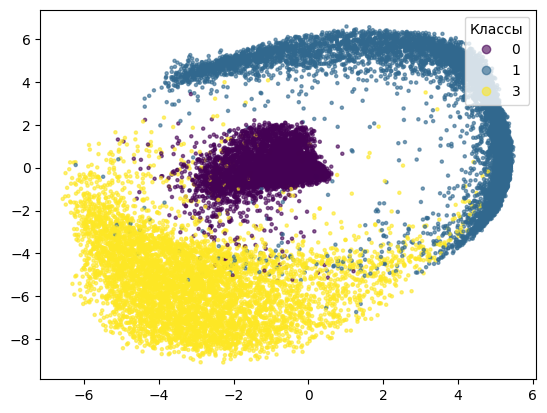

________________________
*** ЭПОХА: 2, loss: 0.03629821538925171 ***
________________________
588/588 [==============================] - 1s 2ms/step


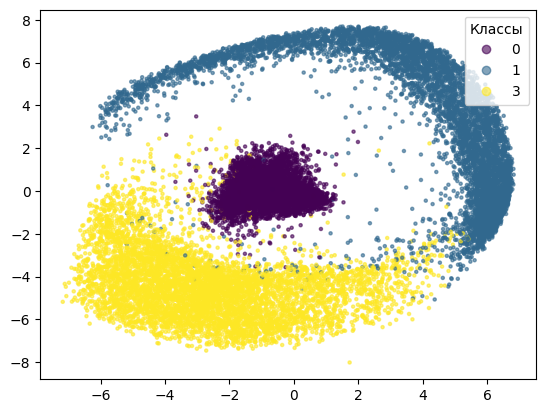

________________________
*** ЭПОХА: 3, loss: 0.034723687916994095 ***
________________________
588/588 [==============================] - 2s 3ms/step


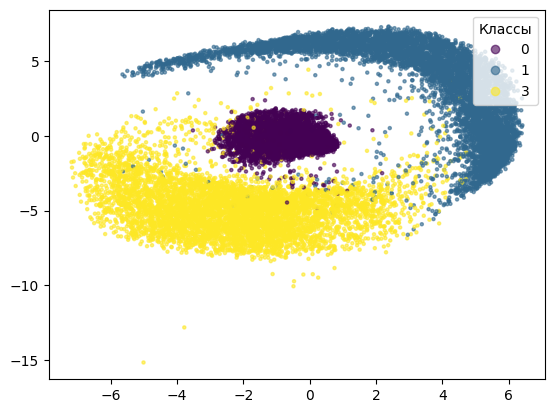

________________________
*** ЭПОХА: 4, loss: 0.03371541574597359 ***
________________________
588/588 [==============================] - 2s 3ms/step


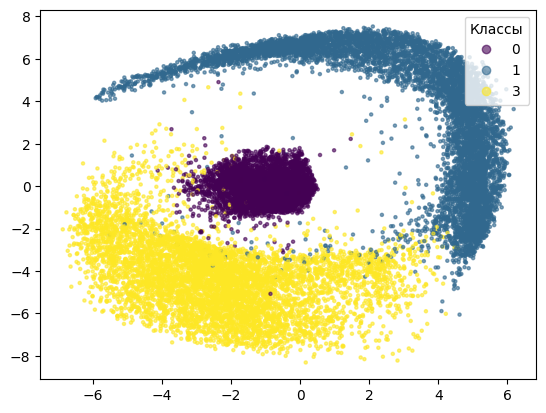

________________________
*** ЭПОХА: 5, loss: 0.03305746987462044 ***
________________________
588/588 [==============================] - 2s 3ms/step


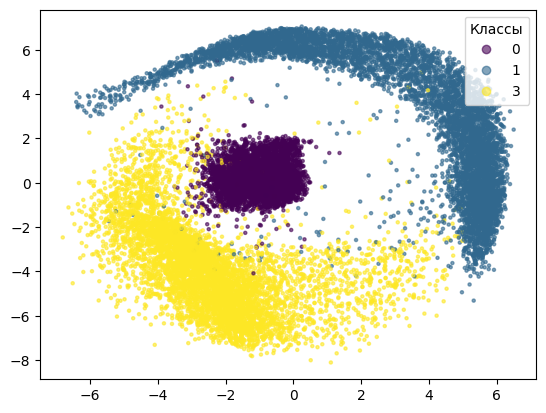

________________________
*** ЭПОХА: 6, loss: 0.032208941876888275 ***
________________________
588/588 [==============================] - 2s 3ms/step


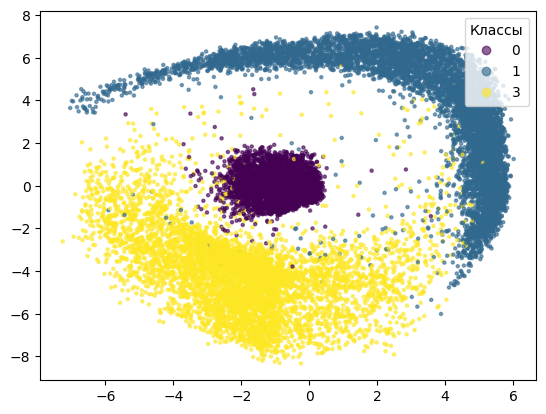

________________________
*** ЭПОХА: 7, loss: 0.03185306861996651 ***
________________________
588/588 [==============================] - 2s 3ms/step


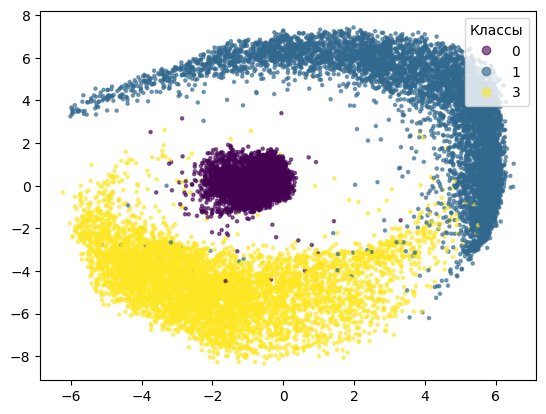

________________________
*** ЭПОХА: 8, loss: 0.031036395579576492 ***
________________________
588/588 [==============================] - 2s 4ms/step


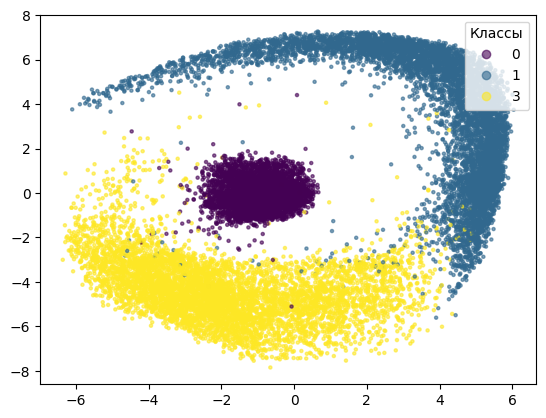

________________________
*** ЭПОХА: 9, loss: 0.03067365288734436 ***
________________________
588/588 [==============================] - 2s 3ms/step


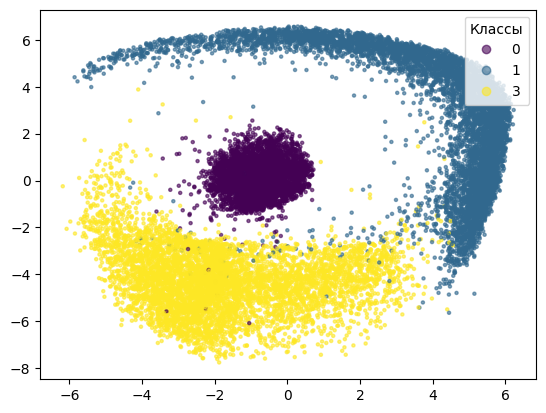

________________________
*** ЭПОХА: 10, loss: 0.03038034960627556 ***
________________________
588/588 [==============================] - 2s 3ms/step


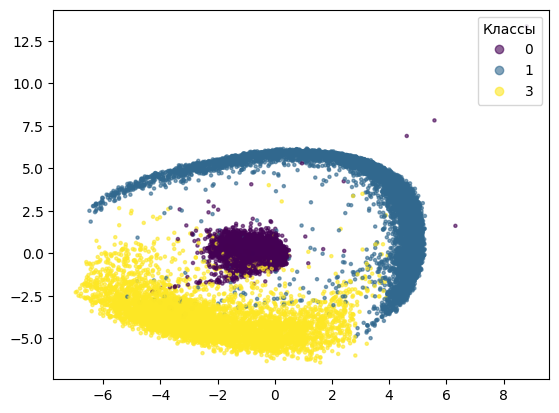

In [ ]:
autoencoder.compile(optimizer=Adam(0.001), loss='mse')

autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=16,
                shuffle=True,
                callbacks = [ae_callback],
                verbose = 0)